## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0294
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 6.4694e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 6.1934e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 5.9810e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 5.8753e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.5489e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.9942e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.6007e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.3807e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.2346e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 4.0713e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.8692e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.6792e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.5209e-04
Epoc

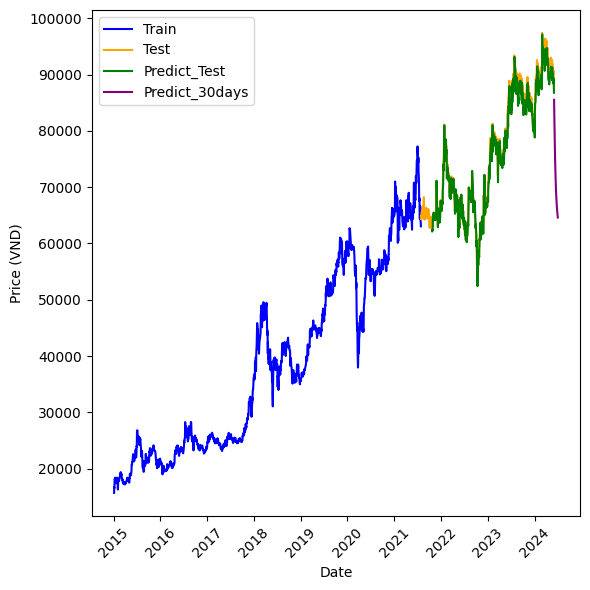

In [2]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  85524.437500
2024-06-02  83889.710938
2024-06-03  82364.593750
2024-06-04  80947.078125
2024-06-05  79603.531250
...                  ...
2024-08-25  59485.394531
2024-08-26  59448.660156
2024-08-27  59412.867188
2024-08-28  59377.996094
2024-08-29  59344.023438

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1522.2167588368263
MAPE: 1.5205584115242734 %
MAE: 1185.8698707651863


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0127
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.2707e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.3707e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.7975e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 7.2760e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.7877e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6.3458e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.9649e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 5.6421e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 5.3671e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.1313e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.9282e-04
Epoch 15/100

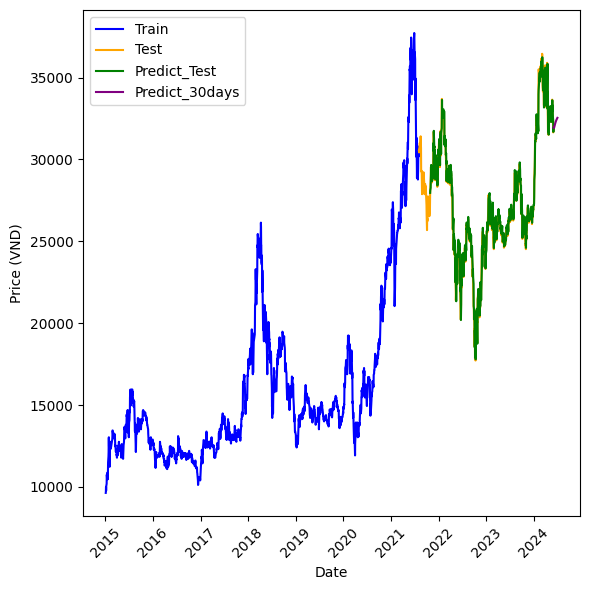

In [6]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('CTG Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  31933.771484
2024-06-02  31933.099609
2024-06-03  31928.007812
2024-06-04  31932.833984
2024-06-05  31949.250000
...                  ...
2024-08-25  32845.707031
2024-08-26  32846.976562
2024-08-27  32848.191406
2024-08-28  32849.351562
2024-08-29  32850.464844

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 566.6617997254531
MAPE: 1.5659168702741537 %
MAE: 413.25638404988354


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0274
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 8.7313e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.0975e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 7.3690e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.5336e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.9438e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.5097e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.2045e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.0286e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.8793e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 4.7474e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 4.6284e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.5193e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.4183e-04
Epoc

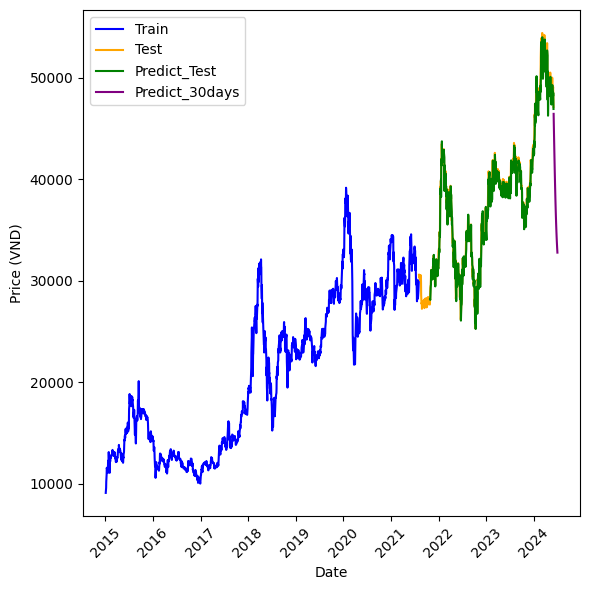

In [10]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('BID Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46436.468750
2024-06-02  45714.089844
2024-06-03  45020.203125
2024-06-04  44342.449219
2024-06-05  43677.222656
...                  ...
2024-08-25  28382.347656
2024-08-26  28346.763672
2024-08-27  28311.642578
2024-08-28  28276.972656
2024-08-29  28242.751953

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 904.4050877942457
MAPE: 1.7487904764651883 %
MAE: 663.7103097098214
